### Sentiment analysis using SVM
Dataset link : https://www.kaggle.com/datasets/davidwallach/financial-tweets?select=stockerbot-export.csv

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bikra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bikra\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\bikra\AppData\Local\Temp\ipykernel_9220\2665229025.py:61: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[~df['Tweets'].str.contains(r'\b(\w{1,2})\b')]


Number of Tweets Analysed = 10744
Positive tweets = 2427
Negative tweets = 727
Neutral tweets = 7590
Training accuracy: 0.9880162885398488
Testing accuracy: 0.9669613773848301
Confusion Matrix Training:
[[ 545   45    5]
 [   0 6066    1]
 [   2   50 1881]]
Classification Report T:
              precision    recall  f1-score   support

    Negative       1.00      0.92      0.95       595
     Neutral       0.98      1.00      0.99      6067
    Positive       1.00      0.97      0.98      1933

    accuracy                           0.99      8595
   macro avg       0.99      0.96      0.98      8595
weighted avg       0.99      0.99      0.99      8595

Confusion Matrix Validation:
[[ 109   20    3]
 [   0 1521    2]
 [   6   40  448]]
Classification Report V:
              precision    recall  f1-score   support

    Negative       0.95      0.83      0.88       132
     Neutral       0.96      1.00      0.98      1523
    Positive       0.99      0.91      0.95       494

    accur

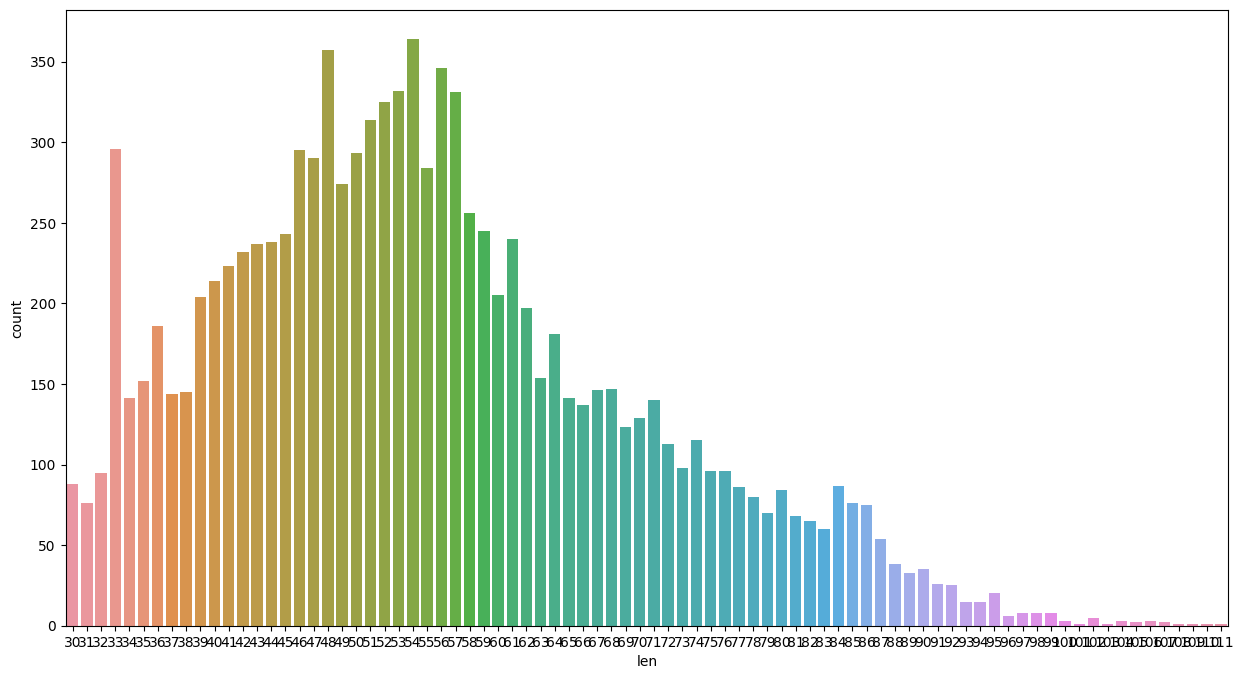

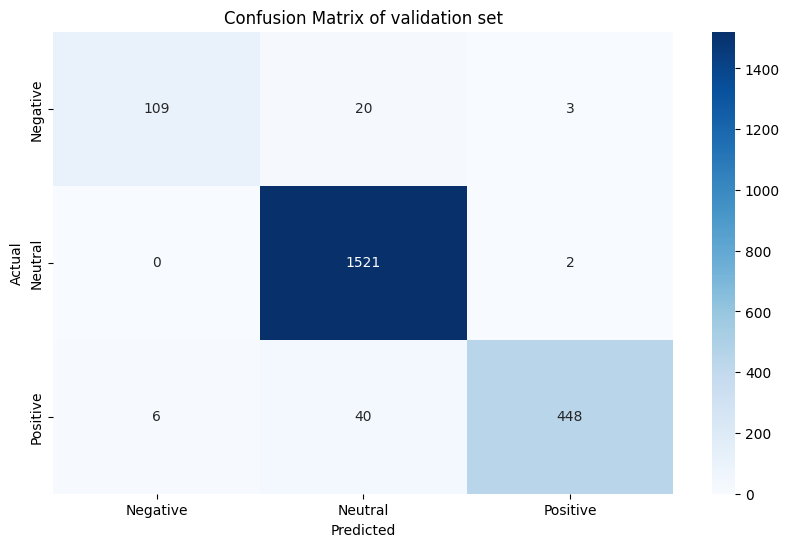

In [3]:
# Import necessary libraries
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from collections import Counter
from string import punctuation
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the dataset
df = pd.read_csv("stockerbot-export1.csv")

# Function to clean tweets
def clean_tweets(text):
    # Check if the input is a string
    if isinstance(text, str):
        # Define regex patterns
        pat1 = r'@[A-Za-z0-9]+'
        pat2 = r'https?://[A-Za-z0-9./]+'
        combined_pat = r'|'.join((pat1, pat2))
        pat3 = r'[^a-zA-Z]'

        # Initialize stemmer, lemmatizer, stopwords, and punctuation
        ps = PorterStemmer()
        lemmatizer = WordNetLemmatizer()
        stop_words = set(stopwords.words('english'))
        punctuations = set(punctuation)

        # Clean the text
        cleaned_text = re.sub(combined_pat, ' ', text)
        cleaned_text = re.sub(pat3, ' ', cleaned_text)
        cleaned_text = cleaned_text.lower()
        cleaned_text = cleaned_text.split()
        cleaned_text = [lemmatizer.lemmatize(ps.stem(word)) for word in cleaned_text if word not in stop_words and word not in punctuations]
        cleaned_text = ' '.join(cleaned_text)

        return cleaned_text
    else:
        return ''

# Apply the cleaning function to the 'text' column
df['tweets'] = df['text'].apply(clean_tweets)

# Create a new dataframe with cleaned tweets
df = pd.DataFrame({"Tweets": df['tweets']})

# Filter out rows with less than 4 words and rows with single or pairs of characters
df = df[df['Tweets'].str.split().str.len() > 3]
df = df[~df['Tweets'].str.contains(r'\b(\w{1,2})\b')]
df = df[df['Tweets'].str.len() >= 30]

# Calculate sentiment scores
df[['Polarity', 'Subjectivity']] = df['Tweets'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

# Save the cleaned data
df.to_csv('clean1_stockerbot-export1.csv', index=False)

# Load the cleaned data
df = pd.read_csv("clean1_stockerbot-export1.csv")

# Count positive, negative, and neutral tweets
sentiment_counts = Counter('positive' if a > 0 else 'negative' if a < 0 else 'neutral' for a in df['Polarity'])

# Print the counts
print(f'Number of Tweets Analysed = {sum(sentiment_counts.values())}')
print(f'Positive tweets = {sentiment_counts["positive"]}')
print(f'Negative tweets = {sentiment_counts["negative"]}')
print(f'Neutral tweets = {sentiment_counts["neutral"]}')

# Label the tweets based on sentiment scores
df['labels'] = df['Polarity'].apply(lambda x: "Positive" if x > 0 else "Neutral" if x == 0 else "Negative")

# Save the labeled data
df.to_csv('labeled_stockerbot-export1.csv', index=False)

# Load the labeled data
df = pd.read_csv("labeled_stockerbot-export1.csv", usecols=['Tweets', 'labels'])

# Replace NaN values in 'Tweets' column with empty strings
df["Tweets"].fillna("", inplace=True)

# Plot the distribution of tweet lengths
df["len"] = df["Tweets"].apply(lambda words: len(words))
plt.figure(figsize=(15, 8))
sns.countplot(data=df, x="len")

# Split the data into training and testing sets
data = df["Tweets"]
labels = df["labels"]

# Apply TF-IDF vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Train the SVM classifier with cross-validation
clf = SVC(kernel='linear')
scores = cross_val_score(clf, X_train, y_train, cv=5)
clf.fit(X_train, y_train)

# Make predictions and evaluate the performance
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
print("Training accuracy:", accuracy_score(y_train, y_train_pred))
print("Testing accuracy:", accuracy_score(y_test, y_test_pred))

# Print confusion matrices and classification reports
print("Confusion Matrix Training:")
print(confusion_matrix(y_train, y_train_pred))
print("Classification Report T:")
print(classification_report(y_train, y_train_pred))
print("Confusion Matrix Validation:")
print(confusion_matrix(y_test, y_test_pred))
print("Classification Report V:")
print(classification_report(y_test, y_test_pred))

# Plot the heatmap of the confusion matrix
plt.figure(figsize=(10, 6))
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of validation set')
plt.show()